<a href="https://colab.research.google.com/github/yoshi108-102/ml-project/blob/main/Extract_PCCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 瞳孔検出アルゴリズム (PCCR法) の仕様

本アルゴリズムは、MediaPipe等の顔ランドマーク検出ライブラリが使用できない、目の領域のみが映った動画（近赤外線カメラ想定）に対し、PCCR（Pupil Center Corneal Reflection）法に基づき瞳孔中心（PC）とプルキンエ像（CR）を検出します。

## 処理フロー

1.  **前処理**: 動画フレームをグレースケール化し、CLAHE（適応的ヒストグラム平坦化）を適用してエッジを強調します。
2.  **ノイズ除去**: CLAHE適用後の画像に対し、ガウシアンブラーを適用して微細なノイズ（虹彩の模様など）を平滑化します。
3.  **CR検出**: 元のグレースケール画像（ノイズ除去前）から、指定ROI内で最も輝度が高い点をプルキンエ像（CR）として検出します (`find_purkinje`)。
4.  **シード検出**: CRの周辺（`SEED_SEARCH_RADIUS`内）の「暗い領域」を二値化で抽出し、その重心（Centroid）を瞳孔探索のシード点として検出します (`find_pupil_seed_centroid`)。
5.  **PC検出 (Starburst)**: 安定したシード点を中心に、放射状（`NUM_RAYS`本）にレイを伸ばし、輝度勾配が最大となる点（`GRADIENT_THRESHOLD`以上）を瞳孔のエッジ候補点として収集します。
6.  **楕円フィッティング**: 収集したエッジ点群に対し、ロバストな楕円フィッティング（`fitEllipseAMS`）を行い、その中心を瞳孔中心（PC）として算出します (`find_pupil_starburst_processing`)。
7.  **距離フィルタリング**: 検出されたPCとCR間の距離を計算し、`MAX_PC_CR_DISTANCE` を超える場合はノイズとみなし、検出結果を破棄します。

## 主要な関数

### `create_roi_mask(image_shape, top_margin)`

-   **入力**: 画像のシェイプ `image_shape`, 無視する上部マージン `top_margin`
-   **出力**: 指定した上部マージン領域が0（黒）、それ以外が255（白）のROIマスク画像（`np.uint8`）。

### `find_purkinje(gray_image, mask)`

-   **入力**: グレースケール画像 `gray_image`, ROIマスク `mask`
-   **出力**: マスク領域内で最も輝度が高い点の座標（プルキンエ像, CR） `(x, y)`。

### `find_pupil_seed_centroid(gray_image_for_seed, mask, purkinje_loc, debug_image=None)`

-   **入力**: シード検出用のグレースケール画像 `gray_image_for_seed` (通常はブラー適用後), ROIマスク `mask`, CR座標 `purkinje_loc`
-   **出力**: CR周辺の最も暗い領域の重心（シード点） `(x, y)`。

### `find_pupil_starburst_processing(gray_blurred, mask, purkinje_loc)`

-   **入力**: ブラー適用後のグレースケール画像 `gray_blurred`, ROIマスク `mask`, CR座標 `purkinje_loc`
-   **出力**: Starburst法と楕円フィッティング（AMS）によって検出された瞳孔中心（PC）の座標 `(x, y)`。検出失敗時は `(-1, -1)`。

### `find_pupil_starburst_debug(gray_blurred, mask, purkinje_loc)`

-   **入力**: `find_pupil_starburst_processing` と同じ。
-   **出力**: 瞳孔中心 `(x, y)`, 検出された楕円情報 `pupil_ellipse`, Starburstの探索過程を描画したデバッグ画像 `debug_image`。

### `debug_specific_frame(frames_list, frame_index)`

-   **入力**: 全フレームのリスト `frames_list`, 解析対象のフレーム番号 `frame_index`
-   **処理**: 指定された単一フレームに対してPCCR処理の全ステップを実行し、中間画像（グレースケール、CLAHE、ブラー、Starburst探索結果）と最終結果を `cv2_imshow` で表示する。

### `process_frames_to_video(frames_list, output_path)`

-   **入力**: 全フレームのリスト `frames_list`, 出力動画パス `output_path`
-   **処理**: `frames_list` 内の全フレームをループ処理し、PCCR検出を実行。CR（緑）とPC（赤）を元のフレームに描画し、指定されたパスにMP4動画として書き出す。
-   **出力**: 処理結果の統計（成功フレーム数、フィルタ除外フレーム数）をコンソールに出力する。

In [ ]:
# (Colabセル 1: フレーム読み込み)
import cv2
import numpy as np
import math
import sys
import random
from google.colab.patches import cv2_imshow # Colab用の表示関数

# --- ビデオファイルパス ---
INPUT_VIDEO_PATH = 'eye_data2.mp4'

video_path = INPUT_VIDEO_PATH
cap = cv2.VideoCapture(video_path)

frames_list = [] # 全てのフレームを格納するリスト

if not cap.isOpened():
    print(f"エラー: {video_path} を開けません。ファイルが正しくアップロードされているか確認してください。")
else:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # -----------------------------------------------------
        # ★ 元のコードのクロップ処理をここに移動
        # -----------------------------------------------------
        original_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        original_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        crop_width_start = original_width // 2
        output_height = original_height

        eye_image_frame = frame[0:output_height, crop_width_start:original_width]
        # -----------------------------------------------------

        frames_list.append(eye_image_frame) # クロップ後のフレームをリストに追加

    cap.release()
    print(f"動画の読み込み完了。合計 {len(frames_list)} フレーム。")

    # 読み込んだフレームから動画のプロパティを取得 (メインループで使用)
    if frames_list:
        frame_height, frame_width = frames_list[0].shape[:2]
        # FPSは元の動画から取得する必要があるため、再度開く
        cap_props = cv2.VideoCapture(video_path)
        VIDEO_FPS = cap_props.get(cv2.CAP_PROP_FPS)
        cap_props.release()
        print(f"クロップ後解像度: {frame_width}x{frame_height}, FPS: {VIDEO_FPS:.2f}")
    else:
        print("エラー: フレームが読み込めませんでした。")

動画の読み込み完了。合計 2262 フレーム。
クロップ後解像度: 320x240, FPS: 24.00


In [ ]:
# (Colabセル 2: アルゴリズム関数群)

ROI_TOP_MARGIN = 30
NUM_RAYS = 60
GRADIENT_THRESHOLD = 13
PUPIL_MIN_RADIUS = 10
PUPIL_MAX_RADIUS = 40
SEED_SEARCH_RADIUS = 30
LOWER_HALF_WEIGHT = 2
MAX_PC_CR_DISTANCE = 50

CLAHE_CLIP_LIMIT = 2.0
CLAHE_GRID_SIZE = (8, 8)

GAUSSIAN_BLUR_KERNEL_SIZE = (5, 5)

PUPIL_SEED_THRESHOLD_OFFSET = 30

KF_PROCESS_NOISE = 1e-3 # 1e-4から調整
KF_MEASUREMENT_NOISE = 1e-2 # 1e-1から調整
KF_DT = 1.0

clahe = cv2.createCLAHE(clipLimit=CLAHE_CLIP_LIMIT, tileGridSize=CLAHE_GRID_SIZE)


def initialize_kalman_filter():
    """
    等速直線運動モデルに基づき、4状態(x, y, vx, vy) / 2観測(x, y) の
    カルマンフィルタを初期化して返す。
    """
    state_dim = 4
    measure_dim = 2

    kf = cv2.KalmanFilter(state_dim, measure_dim)

    dt = KF_DT

    kf.transitionMatrix = np.array([
        [1, 0, dt, 0],
        [0, 1, 0, dt],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ], dtype=np.float32)

    kf.measurementMatrix = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0]
    ], dtype=np.float32)

    kf.processNoiseCov = np.eye(state_dim, dtype=np.float32) * KF_PROCESS_NOISE

    kf.measurementNoiseCov = np.eye(measure_dim, dtype=np.float32) * KF_MEASUREMENT_NOISE

    kf.errorCovPost = np.eye(state_dim, dtype=np.float32) * 1.0

    kf.statePost = np.zeros(state_dim, dtype=np.float32)

    return kf

def create_roi_mask(image_shape, top_margin):
    """
    画像全体をROIとし、上部のテキスト領域のみを除外するマスクを作成する
    """
    height, width = image_shape[:2]
    mask = np.full((height, width), 255, dtype=np.uint8)
    if top_margin > 0:
        cv2.rectangle(mask, (0, 0), (width, top_margin), 0, -1)
    return mask

def find_purkinje(gray_image, mask):
    """
    指定されたマスク領域内で、最も明るい点（プルキンエ像）の位置を返す
    """
    _, _, _, purkinje_loc = cv2.minMaxLoc(gray_image, mask=mask)
    return purkinje_loc

def find_pupil_seed_centroid(gray_image_for_seed, mask, purkinje_loc, debug_image=None):
    """
    プルキンエ像の周辺で、最も暗い領域の「重心」をシードとして検出する
    """
    height, width = gray_image_for_seed.shape
    px, py = purkinje_loc

    y_start = max(0, py - SEED_SEARCH_RADIUS)
    y_end = min(height, py + SEED_SEARCH_RADIUS)
    x_start = max(0, px - SEED_SEARCH_RADIUS)
    x_end = min(width, px + SEED_SEARCH_RADIUS)

    seed_search_roi_mask = np.zeros_like(gray_image_for_seed)
    seed_search_roi_mask[y_start:y_end, x_start:x_end] = 255
    seed_search_mask = cv2.bitwise_and(seed_search_roi_mask, mask)

    minVal, _, minLoc, _ = cv2.minMaxLoc(gray_image_for_seed, mask=seed_search_mask)

    threshold_val = minVal + PUPIL_SEED_THRESHOLD_OFFSET
    _, dark_region = cv2.threshold(
        gray_image_for_seed, threshold_val, 255, cv2.THRESH_BINARY_INV
    )

    dark_region_masked = cv2.bitwise_and(dark_region, dark_region, mask=seed_search_mask)

    contours, _ = cv2.findContours(
        dark_region_masked, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    seed_loc = None
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)

        M = cv2.moments(largest_contour)
        if M["m00"] > 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            seed_loc = (cX, cY)

        if debug_image is not None:
            cv2.rectangle(debug_image, (x_start, y_start), (x_end, y_end), (255, 0, 255), 1)
            cv2.drawContours(debug_image, [largest_contour], -1, (255, 255, 0), 1)

    if seed_loc is None:
        seed_loc = minLoc if minLoc != (0, 0) else purkinje_loc

    if debug_image is not None:
        cv2.circle(debug_image, seed_loc, 3, (0, 255, 255), -1)

    return seed_loc

def find_pupil_starburst_debug(gray_blurred, mask, purkinje_loc):
    """
    Starburstアルゴリズムで瞳孔のエッジ点群を検出し、
    中心座標(PC)、楕円、デバッグ画像を返す。
    """
    height, width = gray_blurred.shape
    debug_image = cv2.cvtColor(gray_blurred, cv2.COLOR_GRAY2BGR)

    seed_loc = find_pupil_seed_centroid(gray_blurred, mask, purkinje_loc, debug_image)
    seed_x, seed_y = seed_loc

    edge_points = []

    for i in range(NUM_RAYS):
        angle = (2 * math.pi * i) / NUM_RAYS
        dx, dy = math.cos(angle), math.sin(angle)

        max_grad = -1
        edge_point = None
        prev_intensity = int(gray_blurred[seed_y, seed_x])

        for k in range(PUPIL_MIN_RADIUS, PUPIL_MAX_RADIUS + 1):
            x = int(seed_x + k * dx)
            y = int(seed_y + k * dy)

            if not (0 <= y < height and 0 <= x < width and mask[y, x] > 0):
                break

            current_intensity = int(gray_blurred[y, x])
            gradient = current_intensity - prev_intensity

            if gradient > GRADIENT_THRESHOLD and gradient > max_grad:
                max_grad = gradient
                edge_point = (x, y)

            prev_intensity = current_intensity

        if edge_point:
            is_lower_half = (edge_point[1] > seed_y)
            weight = LOWER_HALF_WEIGHT if is_lower_half else 1
            for _ in range(weight):
                edge_points.append(edge_point)

            if is_lower_half:
                cv2.circle(debug_image, edge_point, 1, (0, 255, 0), -1)
            else:
                cv2.circle(debug_image, edge_point, 1, (255, 100, 0), -1)

    pupil_center = (-1, -1)
    pupil_ellipse = None

    if len(edge_points) >= 6:
        try:
            points_np = np.array(edge_points, dtype=np.float32).reshape(-1, 1, 2)
            pupil_ellipse = cv2.fitEllipseAMS(points_np)
            pupil_center = (int(pupil_ellipse[0][0]), int(pupil_ellipse[0][1]))
        except cv2.error:
            pass

    return pupil_center, pupil_ellipse, debug_image

def find_pupil_starburst_processing(gray_blurred, mask, purkinje_loc):
    """
    Starburstアルゴリズムで瞳孔のエッジ点群を検出し、
    中心座標(PC)と楕円オブジェクトを返す。
    """
    height, width = gray_blurred.shape

    seed_loc = find_pupil_seed_centroid(gray_blurred, mask, purkinje_loc, debug_image=None)
    seed_x, seed_y = seed_loc

    edge_points = []

    for i in range(NUM_RAYS):
        angle = (2 * math.pi * i) / NUM_RAYS
        dx, dy = math.cos(angle), math.sin(angle)

        max_grad = -1
        edge_point = None
        prev_intensity = int(gray_blurred[seed_y, seed_x])

        for k in range(PUPIL_MIN_RADIUS, PUPIL_MAX_RADIUS + 1):
            x = int(seed_x + k * dx)
            y = int(seed_y + k * dy)

            if not (0 <= y < height and 0 <= x < width and mask[y, x] > 0):
                break

            current_intensity = int(gray_blurred[y, x])
            gradient = current_intensity - prev_intensity

            if gradient > GRADIENT_THRESHOLD and gradient > max_grad:
                max_grad = gradient
                edge_point = (x, y)

            prev_intensity = current_intensity

        if edge_point:
            is_lower_half = (edge_point[1] > seed_y)
            weight = LOWER_HALF_WEIGHT if is_lower_half else 1
            for _ in range(weight):
                edge_points.append(edge_point)

    pupil_center = (-1, -1)
    pupil_ellipse = None

    if len(edge_points) >= 6:
        try:
            points_np = np.array(edge_points, dtype=np.float32).reshape(-1, 1, 2)
            pupil_ellipse = cv2.fitEllipseAMS(points_np)
            pupil_center = (int(pupil_ellipse[0][0]), int(pupil_ellipse[0][1]))
        except cv2.error:
            pass

    return pupil_center, pupil_ellipse

In [ ]:
# (Colabセル 2: アルゴリズム関数群)

ROI_TOP_MARGIN = 30
NUM_RAYS = 60
GRADIENT_THRESHOLD = 17
PUPIL_MIN_RADIUS = 10
PUPIL_MAX_RADIUS = 40
SEED_SEARCH_RADIUS = 50
LOWER_HALF_WEIGHT = 2
MAX_PC_CR_DISTANCE = 50

CLAHE_CLIP_LIMIT = 3.0
CLAHE_GRID_SIZE = (8, 8)

GAUSSIAN_BLUR_KERNEL_SIZE = (3, 3)

PUPIL_SEED_THRESHOLD_OFFSET = 15

KF_PROCESS_NOISE = 1e-3
KF_MEASUREMENT_NOISE = 1e-2
KF_DT = 1.0

clahe = cv2.createCLAHE(clipLimit=CLAHE_CLIP_LIMIT, tileGridSize=CLAHE_GRID_SIZE)


def initialize_kalman_filter():
    """
    等速直線運動モデルに基づき、4状態(x, y, vx, vy) / 2観測(x, y) の
    カルマンフィルタを初期化して返す。
    """
    state_dim = 4
    measure_dim = 2

    kf = cv2.KalmanFilter(state_dim, measure_dim)

    dt = KF_DT

    kf.transitionMatrix = np.array([
        [1, 0, dt, 0],
        [0, 1, 0, dt],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ], dtype=np.float32)

    kf.measurementMatrix = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0]
    ], dtype=np.float32)

    kf.processNoiseCov = np.eye(state_dim, dtype=np.float32) * KF_PROCESS_NOISE

    kf.measurementNoiseCov = np.eye(measure_dim, dtype=np.float32) * KF_MEASUREMENT_NOISE

    kf.errorCovPost = np.eye(state_dim, dtype=np.float32) * 1.0

    kf.statePost = np.zeros(state_dim, dtype=np.float32)

    return kf

def create_roi_mask(image_shape, top_margin):
    """
    画像全体をROIとし、上部のテキスト領域のみを除外するマスクを作成する
    """
    height, width = image_shape[:2]
    mask = np.full((height, width), 255, dtype=np.uint8)
    if top_margin > 0:
        cv2.rectangle(mask, (0, 0), (width, top_margin), 0, -1)
    return mask

def find_purkinje(gray_image, mask):
    """
    指定されたマスク領域内で、最も明るい点（プルキンエ像）の位置を返す
    """
    _, _, _, purkinje_loc = cv2.minMaxLoc(gray_image, mask=mask)
    return purkinje_loc

def find_pupil_seed_centroid(gray_image_for_seed, mask, purkinje_loc, debug_image=None):
    """
    プルキンエ像の周辺で、最も暗い領域の「重心」と「その輪郭」を検出する
    """
    height, width = gray_image_for_seed.shape
    px, py = purkinje_loc

    y_start = max(0, py - SEED_SEARCH_RADIUS)
    y_end = min(height, py + SEED_SEARCH_RADIUS)
    x_start = max(0, px - SEED_SEARCH_RADIUS)
    x_end = min(width, px + SEED_SEARCH_RADIUS)

    seed_search_roi_mask = np.zeros_like(gray_image_for_seed)
    seed_search_roi_mask[y_start:y_end, x_start:x_end] = 255
    seed_search_mask = cv2.bitwise_and(seed_search_roi_mask, mask)

    minVal, _, minLoc, _ = cv2.minMaxLoc(gray_image_for_seed, mask=seed_search_mask)

    threshold_val = minVal + PUPIL_SEED_THRESHOLD_OFFSET
    _, dark_region = cv2.threshold(
        gray_image_for_seed, threshold_val, 255, cv2.THRESH_BINARY_INV
    )

    dark_region_masked = cv2.bitwise_and(dark_region, dark_region, mask=seed_search_mask)

    contours, _ = cv2.findContours(
        dark_region_masked, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    seed_loc = None
    largest_contour = None
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)

        M = cv2.moments(largest_contour)
        if M["m00"] > 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            seed_loc = (cX, cY)

        if debug_image is not None:
            cv2.rectangle(debug_image, (x_start, y_start), (x_end, y_end), (255, 0, 255), 1)
            cv2.drawContours(debug_image, [largest_contour], -1, (255, 255, 0), 1)

    if seed_loc is None:
        seed_loc = minLoc if minLoc != (0, 0) else purkinje_loc

    if debug_image is not None:
        cv2.circle(debug_image, seed_loc, 3, (0, 255, 255), -1)

    return seed_loc, largest_contour

def find_pupil_starburst_debug(gray_blurred, mask, purkinje_loc):
    """
    Starburstアルゴリズムで瞳孔のエッジ点群を検出し、
    中心座標(PC)、楕円、デバッグ画像を返す。
    """
    height, width = gray_blurred.shape
    debug_image = cv2.cvtColor(gray_blurred, cv2.COLOR_GRAY2BGR)

    seed_loc, _ = find_pupil_seed_centroid(gray_blurred, mask, purkinje_loc, debug_image)
    seed_x, seed_y = seed_loc

    edge_points = []

    for i in range(NUM_RAYS):
        angle = (2 * math.pi * i) / NUM_RAYS
        dx, dy = math.cos(angle), math.sin(angle)

        max_grad = -1
        edge_point = None
        prev_intensity = int(gray_blurred[seed_y, seed_x])

        for k in range(PUPIL_MIN_RADIUS, PUPIL_MAX_RADIUS + 1):
            x = int(seed_x + k * dx)
            y = int(seed_y + k * dy)

            if not (0 <= y < height and 0 <= x < width and mask[y, x] > 0):
                break

            current_intensity = int(gray_blurred[y, x])
            gradient = current_intensity - prev_intensity

            if gradient > GRADIENT_THRESHOLD and gradient > max_grad:
                max_grad = gradient
                edge_point = (x, y)

            prev_intensity = current_intensity

        if edge_point:
            is_lower_half = (edge_point[1] > seed_y)
            weight = LOWER_HALF_WEIGHT if is_lower_half else 1
            for _ in range(weight):
                edge_points.append(edge_point)

            if is_lower_half:
                cv2.circle(debug_image, edge_point, 1, (0, 255, 0), -1)
            else:
                cv2.circle(debug_image, edge_point, 1, (255, 100, 0), -1)

    pupil_center = (-1, -1)
    pupil_ellipse = None

    if len(edge_points) >= 6:
        try:
            points_np = np.array(edge_points, dtype=np.float32).reshape(-1, 1, 2)
            pupil_ellipse = cv2.fitEllipseAMS(points_np)
            pupil_center = (int(pupil_ellipse[0][0]), int(pupil_ellipse[0][1]))
        # ★ MODIFIED: cv2.error と ValueError の両方をキャッチ
        except (cv2.error, ValueError):
            pass

    return pupil_center, pupil_ellipse, debug_image

def find_pupil_starburst_processing(gray_blurred, mask, purkinje_loc):
    """
    Starburstアルゴリズムで瞳孔のエッジ点群を検出し、
    中心座標(PC)と楕円オブジェクト、およびシード検出時の輪郭を返す。
    """
    height, width = gray_blurred.shape

    seed_loc, largest_contour = find_pupil_seed_centroid(gray_blurred, mask, purkinje_loc, debug_image=None)
    seed_x, seed_y = seed_loc

    edge_points = []

    for i in range(NUM_RAYS):
        angle = (2 * math.pi * i) / NUM_RAYS
        dx, dy = math.cos(angle), math.sin(angle)

        max_grad = -1
        edge_point = None
        prev_intensity = int(gray_blurred[seed_y, seed_x])

        for k in range(PUPIL_MIN_RADIUS, PUPIL_MAX_RADIUS + 1):
            x = int(seed_x + k * dx)
            y = int(seed_y + k * dy)

            if not (0 <= y < height and 0 <= x < width and mask[y, x] > 0):
                break

            current_intensity = int(gray_blurred[y, x])
            gradient = current_intensity - prev_intensity

            if gradient > GRADIENT_THRESHOLD and gradient > max_grad:
                max_grad = gradient
                edge_point = (x, y)

            prev_intensity = current_intensity

        if edge_point:
            is_lower_half = (edge_point[1] > seed_y)
            weight = LOWER_HALF_WEIGHT if is_lower_half else 1
            for _ in range(weight):
                edge_points.append(edge_point)

    pupil_center = (-1, -1)
    pupil_ellipse = None

    if len(edge_points) >= 6:
        try:
            points_np = np.array(edge_points, dtype=np.float32).reshape(-1, 1, 2)
            pupil_ellipse = cv2.fitEllipseAMS(points_np)
            pupil_center = (int(pupil_ellipse[0][0]), int(pupil_ellipse[0][1]))
        # ★ MODIFIED: cv2.error と ValueError の両方をキャッチ
        except (cv2.error, ValueError):
            pass

    return pupil_center, pupil_ellipse, largest_contour

In [ ]:
# (Colabセル 3: 実行・デバッグ用関数群)

def debug_specific_frame(frames_list, frame_index):
    """
    指定されたインデックスのフレームに対し、詳細なデバッグ解析結果を表示する。
    (この関数は時系列フィルタリングを行いません)
    """
    if not frames_list or frame_index < 0 or frame_index >= len(frames_list):
        print(f"エラー: 無効なフレームインデックス {frame_index} です。")
        return

    print(f"全 {len(frames_list)} フレームから、 {frame_index} 番目のフレームを解析します...")

    frame_original = frames_list[frame_index]
    output_frame = frame_original.copy()

    gray = cv2.cvtColor(frame_original, cv2.COLOR_BGR2GRAY)

    gray_enhanced = clahe.apply(gray)

    gray_blurred = cv2.GaussianBlur(gray_enhanced, GAUSSIAN_BLUR_KERNEL_SIZE, 0)

    face_mask = create_roi_mask(gray.shape, ROI_TOP_MARGIN)

    purkinje_loc = find_purkinje(gray, face_mask)

    pupil_center, pupil_ellipse, pupil_debug_image = find_pupil_starburst_debug(
        gray_blurred,
        face_mask,
        purkinje_loc
    )

    is_success = False
    if pupil_center != (-1, -1):
        distance = math.dist(pupil_center, purkinje_loc)
        if distance <= MAX_PC_CR_DISTANCE:
            is_success = True
        else:
            print(f"フィルタ除外: PC-CR間距離が {distance:.1f} > {MAX_PC_CR_DISTANCE}")

    cv2.circle(output_frame, purkinje_loc, 5, (0, 255, 0), 1)
    if is_success:
        cv2.circle(output_frame, pupil_center, 3, (0, 0, 255), -1)
        if pupil_ellipse:
             cv2.ellipse(output_frame, pupil_ellipse, (255, 0, 0), 2)

    print(f"\n[デバッグ1: クロップされたオリジナル画像]")
    cv2_imshow(frame_original)

    print(f"\n[デバッグ2: グレースケール画像 (gray)]")
    cv2_imshow(gray)

    print(f"\n[デバッグ3: CLAHE適用（エッジ強調）画像 (gray_enhanced)]")
    cv2_imshow(gray_enhanced)

    print(f"\n[デバッグ4: ガウシアンブラー適用画像 (gray_blurred)]")
    cv2_imshow(gray_blurred)

    print(f"\n[デバッグ5: Starburst探索結果 (紫=ROI, 黄=シード/輪郭, 緑/青=エッジ点)]")
    cv2_imshow(pupil_debug_image)

    print(f"\n[最終結果: {frame_index} 番目のフレーム]")
    print(f"  プルキンエ像 (CR): {purkinje_loc}")
    print(f"  瞳孔中心 (PC): {pupil_center if is_success else '失敗'}")
    cv2_imshow(output_frame)


def process_frames_to_video(frames_list, output_path, fps, width, height):
    """
    frames_listをループ処理し、結果を動画ファイルに書き出す
    (★ カルマンフィルタによる平滑化 + シード領域の輪郭描画を適用)
    """
    if not frames_list:
        print("エラー: 処理対象のフレームがありません。")
        return

    OUTPUT_VIDEO_PATH = output_path

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(OUTPUT_VIDEO_PATH, fourcc, fps, (width, height))

    print(f"'{output_path}' への書き出し処理を開始します (★平滑化ON, 輪郭描画ON)...")
    print(f"解像度: {width}x{height}, FPS: {fps:.2f}, 全{len(frames_list)}フレーム")
    print(f"距離フィルタしきい値: {MAX_PC_CR_DISTANCE} ピクセル")

    frame_count = 0
    success_frame_count = 0
    filtered_frame_count = 0

    KF_PC = initialize_kalman_filter()
    KF_CR = initialize_kalman_filter()
    pc_initialized = False
    cr_initialized = False

    last_known_raw_pc = None
    last_known_largest_contour = None

    for frame_original in frames_list:
        frame_count += 1
        output_frame = frame_original.copy()

        gray = cv2.cvtColor(frame_original, cv2.COLOR_BGR2GRAY)
        gray_enhanced = clahe.apply(gray)
        gray_blurred = cv2.GaussianBlur(gray_enhanced, GAUSSIAN_BLUR_KERNEL_SIZE, 0)
        face_mask = create_roi_mask(gray.shape, ROI_TOP_MARGIN)

        purkinje_loc_raw = find_purkinje(gray, face_mask)

        pupil_center_raw, pupil_ellipse_raw, largest_contour_raw = find_pupil_starburst_processing(
            gray_blurred,
            face_mask,
            purkinje_loc_raw
        )

        is_pc_success = False
        if pupil_center_raw != (-1, -1) and pupil_ellipse_raw is not None:
            distance = math.dist(pupil_center_raw, purkinje_loc_raw)
            if distance <= MAX_PC_CR_DISTANCE:
                is_pc_success = True
                last_known_raw_pc = pupil_center_raw
                if largest_contour_raw is not None:
                    last_known_largest_contour = largest_contour_raw
            else:
                filtered_frame_count += 1

        KF_PC.predict()
        KF_CR.predict()

        measurement_cr = np.array([purkinje_loc_raw[0], purkinje_loc_raw[1]], dtype=np.float32)
        if not cr_initialized:
            KF_CR.statePost[0] = measurement_cr[0]
            KF_CR.statePost[1] = measurement_cr[1]
            KF_CR.statePost[2] = 0.0
            KF_CR.statePost[3] = 0.0
            KF_CR.errorCovPost = np.eye(4, dtype=np.float32) * 1.0
            cr_initialized = True
        else:
            KF_CR.correct(measurement_cr)

        if is_pc_success:
            success_frame_count += 1
            measurement_pc = np.array([pupil_center_raw[0], pupil_center_raw[1]], dtype=np.float32)

            if not pc_initialized:
                KF_PC.statePost[0] = measurement_pc[0]
                KF_PC.statePost[1] = measurement_pc[1]
                KF_PC.statePost[2] = 0.0
                KF_PC.statePost[3] = 0.0
                KF_PC.errorCovPost = np.eye(4, dtype=np.float32) * 1.0
                pc_initialized = True
            else:
                KF_PC.correct(measurement_pc)

        pupil_center_smooth = (int(KF_PC.statePost[0]), int(KF_PC.statePost[1]))
        purkinje_loc_smooth = (int(KF_CR.statePost[0]), int(KF_CR.statePost[1]))

        if cr_initialized:
             cv2.circle(output_frame, purkinje_loc_smooth, 5, (0, 255, 0), 1)

        if pc_initialized and last_known_raw_pc is not None:
            cv2.circle(output_frame, pupil_center_smooth, 3, (0, 0, 255), -1)

            if last_known_largest_contour is not None and last_known_raw_pc != (-1, -1):
                offset_x = pupil_center_smooth[0] - last_known_raw_pc[0]
                offset_y = pupil_center_smooth[1] - last_known_raw_pc[1]
                offset_tuple = (offset_x, offset_y)

                # 水色 (255, 255, 0) で輪郭を描画
                cv2.drawContours(output_frame, [last_known_largest_contour], -1, (255, 255, 0), 1, offset=offset_tuple)

        out.write(output_frame)

        if frame_count % 30 == 0:
            progress_text = (
                f"\r処理中: {frame_count} / {len(frames_list)} "
                f"(センシング成功: {success_frame_count}, フィルタ除外: {filtered_frame_count})"
            )
            sys.stdout.write(progress_text)
            sys.stdout.flush()

    out.release()
    print(f"\n処理が完了しました。")
    print(f"  全 {frame_count} フレームを保存しました。")
    print(f"  うちセンシング成功フレーム: {success_frame_count} (KF更新回数)")
    print(f"  フィルタ除外フレーム: {filtered_frame_count}")
    print(f"  '{OUTPUT_VIDEO_PATH}' として保存されました。")

In [ ]:
# (Colabセル 5: メイン処理実行)

OUTPUT_VIDEO_PATH = 'eye_tracking_output_improved.mp4'

# 読み込まれたフレームリストとプロパティがあるか確認
if 'frames_list' in locals() and frames_list and 'VIDEO_FPS' in locals():
    # メイン処理関数を実行
    process_frames_to_video(
        frames_list,
        OUTPUT_VIDEO_PATH,
        VIDEO_FPS,
        frame_width,
        frame_height
    )
else:
    print("エラー: 'frames_list' または動画プロパティが存在しません。セル1を先に実行してください。")

'eye_tracking_output_improved.mp4' への書き出し処理を開始します (★平滑化ON, 輪郭描画ON)...
解像度: 320x240, FPS: 24.00, 全2262フレーム
距離フィルタしきい値: 50 ピクセル
処理中: 2250 / 2262 (センシング成功: 2061, フィルタ除外: 93)
処理が完了しました。
  全 2262 フレームを保存しました。
  うちセンシング成功フレーム: 2072 (KF更新回数)
  フィルタ除外フレーム: 93
  'eye_tracking_output_improved.mp4' として保存されました。


全 2262 フレームから、 1749 番目のフレームを解析します...

[デバッグ1: クロップされたオリジナル画像]


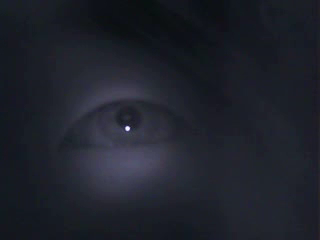


[デバッグ2: グレースケール画像 (gray)]


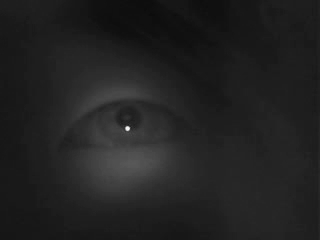


[デバッグ3: CLAHE適用（エッジ強調）画像 (gray_enhanced)]


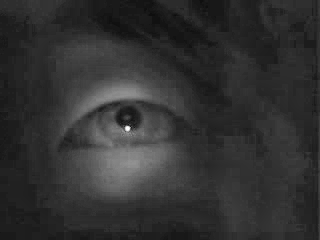


[デバッグ4: ガウシアンブラー適用画像 (gray_blurred)]


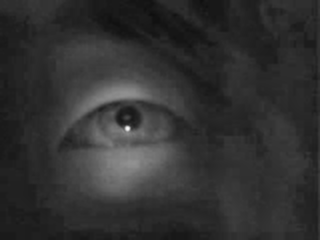


[デバッグ5: Starburst探索結果 (紫=ROI, 黄=シード/輪郭, 緑/青=エッジ点)]


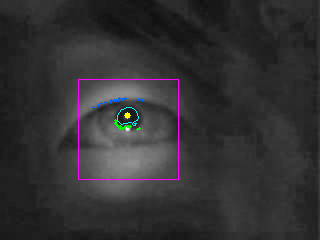


[最終結果: 1749 番目のフレーム]
  プルキンエ像 (CR): (128, 129)
  瞳孔中心 (PC): (141, 114)


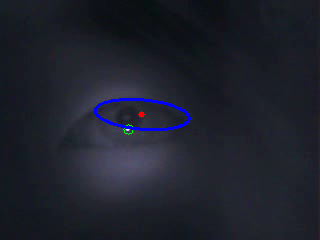

In [ ]:
# (Colabセル 4: デバッグ実行)

# 読み込まれたフレームリストがあるか確認
if 'frames_list' in locals() and frames_list:
    # ランダムなフレームインデックスを決定
    random_frame_index = random.randint(0, len(frames_list) - 1)

    # デバッグ関数を実行
    debug_specific_frame(frames_list, random_frame_index)
else:
    print("エラー: 'frames_list' が存在しません。セル1を先に実行してください。")